In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset

In [6]:
from digit_recognizer.modeling.load_data import load_data
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn
# Initiate device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# weights = ResNet50_Weights.DEFAULT
# transform = weights.transforms()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load data
train_loader, val_loader = load_data(transform=transform)

## Set up model
# model = resnet50(weights=weights).to(device)
# # Freeze all the base layers
# for param in model.parameters():
#     param.requires_grad = False
#     
# model.fc = nn.Sequential(                         # You can use torchinfo to see the name of the last layer (here 'fc')
#     nn.Dropout(p=0.2, inplace=True),
#     nn.Linear(in_features=2048, out_features=10),  # It helps to use torchinfo as below to see correct in_features
# )

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MNISTModel()
model.to(device)

MNISTModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [7]:
from digit_recognizer.modeling.train import train
num_epochs = 20

train(num_epochs=num_epochs, 
      model=model, 
      train_loader=train_loader, 
      val_loader=val_loader,
      device=device,
      criterion=nn.CrossEntropyLoss(), 
      optimizer=torch.optim.SGD(model.parameters(), lr=0.001),
      model_save_path="model.pth")

Overall Training Progress: 100%|██████████| 20/20 [03:33<00:00, 10.68s/it, Best Val Accuracy=96.92%, Current Train Accuracy=97.28%, Current Val Accuracy=96.92%]


Label: 4


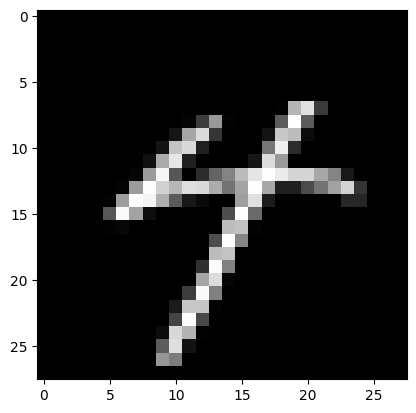

In [29]:
import torch
random_index = random.randint(0, 42000)
image, label = train_data[random_index]
plt.imshow(image, cmap="gray")
print("Label:", label)

In [8]:
df = pd.read_csv('../data/raw/digit-recognizer/train.csv').drop('label', axis=1).values
for example in df:
    example.reshape((28, 28))

In [15]:
df[0].reshape((28, 28))
df[0].shape

(784,)

In [17]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/raw/digit-recognizer/train.csv').drop('label', axis=1)
# Assuming your DataFrame is called 'df'
def row_to_matrix(row):
    return np.array(row).reshape(28, 28)

# Apply the function to each row
matrices = df.apply(row_to_matrix, axis=1)

In [32]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch
from torchinfo import summary
# Initiate device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get the pretrained model
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights).to(device)

In [33]:
# Get the weight transforms
transform = weights.transforms()

# Freeze all the base layers
for param in model.parameters():
    param.requires_grad = False

In [34]:
from torchinfo import summary
summary(model=model,
        input_size=(1, 3, 224, 224),  # Example but make sure this matches what the model expects
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 1000]            --                   False
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    └─

In [35]:
model.fc = nn.Sequential(                         # You can use torchinfo to see the name of the last layer (here 'fc')
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=2048, out_features=10),  # It helps to use torchinfo as below to see correct in_features
)